In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
# from w207_util import *


2022-07-10 22:51:14.750175: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [10]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [2]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3446)


In [3]:

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)

print(init_df.head())

features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

init_df.head()
print(init_df.columns)


y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)



   lag1_mean_0  lag1_mean_1  lag1_mean_2  lag1_mean_3  lag1_mean_4  \
0     0.165685    -0.852441     0.305529     0.069311    -0.820157   
1    -1.280358    -3.529726     1.199699    -1.149790     0.738967   
2     1.830922    -1.242559     0.019590    -0.955141     4.069830   
3     0.726474    -0.013534     3.577241    -1.806816     0.604612   
4    -0.338823     0.202537    -0.062122    -1.623981    -0.346947   

   lag1_mean_5  lag1_mean_6  lag1_mean_7  lag1_mean_8  lag1_mean_9  ...  \
0     0.671192    -0.889876     0.491933    -0.284130     0.031775  ...   
1    -4.185435    -1.864589    -0.710929     2.279327     0.201870  ...   
2    -8.934466     0.863457     1.437240    -1.496749     0.993456  ...   
3    -0.489957     0.936905    -2.145070    -0.171676    -0.505224  ...   
4    -0.717592    -1.123954    -1.435684     0.115600    -1.780939  ...   

   freq_669_12  freq_679_12  freq_689_12  freq_699_12  freq_709_12  \
0     0.010112     0.002127     0.010123     0.004699     

In [25]:
def train_model(x_train, y_train,x_validate, y_validate,
                save_to, epoch = 2, num_of_conv_layer=1, conv_layer_2_filters=64,
                conv_layer_3_filters=128,
                num_of_dense_layer=0, 
                dense_layer_1_unit=1024, dense_layer_2_unit=512, dense_layer_3_unit=256):
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    with strategy.scope():   
        model = Sequential()
        
        model.add(tf.keras.layers.Conv1D(
            filters=32,                
            kernel_size=3,
            strides=1,
            padding='same',
            data_format='channels_last',
            name='conv_1',
            activation='relu'))
        
        model.add(tf.keras.layers.MaxPool1D(
            pool_size=2,
            name='pool_1'))
        
        if (num_of_conv_layer >= 2):
            # add second convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_2_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_2',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_2')
            )
            
        if (num_of_conv_layer >= 3):
            # add 3rd convolutional layer
            model.add(tf.keras.layers.Conv1D(
                filters=conv_layer_3_filters,
                kernel_size=3,
                strides=1,
                padding='same',
                name='conv_3',
                activation='relu'))

            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2, 
                name='pool_3')
            )

        model.add(Flatten()) 
        
        # Add Dense layer
        if (num_of_dense_layer >= 1):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_1_unit,
                name='fc_1', 
                activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 2):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_2_unit,
            name='fc_2', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))
        
        if (num_of_dense_layer >= 3):
            model.add(tf.keras.layers.Dense(
            units=dense_layer_3_unit,
            name='fc_3', 
            activation='relu'))

            # add dropout layer
            model.add(tf.keras.layers.Dropout(
                rate=0.5))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, X_train.shape[1], 1))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model_lstm_all_cat.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
            
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy'])
        
    history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_validate, y_validate),
                        callbacks=[es,mc,lr_schedule])
        
#     saved_model = load_model(save_to + '_best_model_lstm_all_cat.h5')
        
    return model,history


In [5]:

model,history = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2022-07-10 22:51:45.443414: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-10 22:51:45.444225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-10 22:51:45.497258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:67:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-10 22:51:45.497778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-07-10 22:51:45.497802: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-

Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 55104)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 220420    
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 220,548
Trainable params: 220,548
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job

2022-07-10 22:51:47.435540: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_201"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

2022-07-10 22:51:50.303458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-10 22:51:50.674358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


748/752 [============================>.] - ETA: 0s - loss: 35.8397 - accuracy: 0.3504

2022-07-10 22:51:56.381736: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_3308"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.aut

752/752 [==============================] - 11s 8ms/step - loss: 35.7199 - accuracy: 0.3507 - val_loss: 1.5239 - val_accuracy: 0.4767

Epoch 00001: val_accuracy improved from -inf to 0.47667, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 4s 6ms/step - loss: 1.4484 - accuracy: 0.4795 - val_loss: 1.5544 - val_accuracy: 0.4799

Epoch 00002: val_accuracy improved from 0.47667 to 0.47991, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 4s 6ms/step - loss: 1.2857 - accuracy: 0.5194 - val_loss: 1.3386 - val_accuracy: 0.5042

Epoch 00003: val_accuracy improved from 0.47991 to 0.50424, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 4s 6ms/step - loss: 1.3285 - accuracy: 0.5210 - val_loss: 1.3093 - val_accuracy: 0.5091

Epoch 00004: val_accuracy improved from 0.50424 to 0.50911, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40
752/7

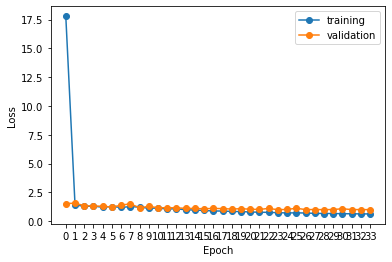

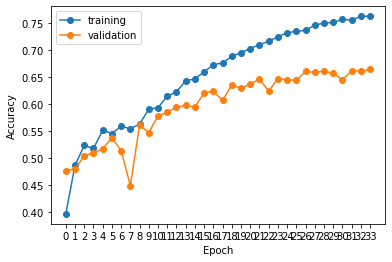

In [7]:
history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

In [8]:
# test model
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

 36/251 [===>..........................] - ETA: 0s - loss: 1.0680 - accuracy: 0.6736

2022-07-10 22:54:22.893303: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_77440"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

251/251 [==============================] - 1s 3ms/step - loss: 1.0301 - accuracy: 0.6682

Test Acc. 66.82%


In [12]:
model2,history2 = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40, 
                              num_of_conv_layer=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 55104)             0         
_________________________________________________________________
dense (Dense)     

2022-07-10 23:00:08.255985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_78369"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
751/752 [============================>.] - ETA: 0s - loss: 6.9623 - accuracy: 0.3318

2022-07-10 23:00:15.724286: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_81708"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.au

752/752 [==============================] - 10s 9ms/step - loss: 6.9509 - accuracy: 0.3319 - val_loss: 1.3102 - val_accuracy: 0.4004

Epoch 00001: val_accuracy improved from -inf to 0.40042, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 5s 7ms/step - loss: 1.2795 - accuracy: 0.4354 - val_loss: 1.2568 - val_accuracy: 0.4382

Epoch 00002: val_accuracy improved from 0.40042 to 0.43823, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 5s 7ms/step - loss: 1.1810 - accuracy: 0.5071 - val_loss: 1.1686 - val_accuracy: 0.5129

Epoch 00003: val_accuracy improved from 0.43823 to 0.51285, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 5s 7ms/step - loss: 1.0750 - accuracy: 0.5687 - val_loss: 1.1345 - val_accuracy: 0.5417

Epoch 00004: val_accuracy improved from 0.51285 to 0.54168, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40
752/75

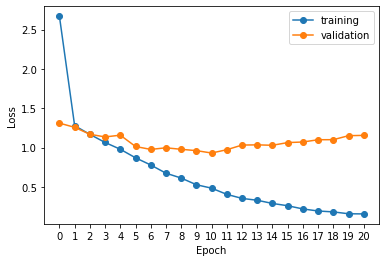

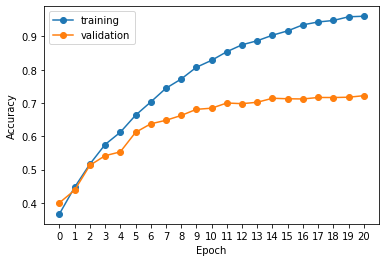

In [13]:
history2_data = pd.DataFrame(history2.history)
plot_loss_history(history2_data)
plot_accuracy_history(history2_data)

In [14]:
# test model
test2_results = model2.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test2_results[1]*100))

 35/251 [===>..........................] - ETA: 0s - loss: 1.1761 - accuracy: 0.7411

2022-07-10 23:04:12.029869: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_127608"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

251/251 [==============================] - 1s 3ms/step - loss: 1.2376 - accuracy: 0.7315

Test Acc. 73.15%


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 861, 128)          24704     
_________________________________________________________________
pool_3 (MaxPooling

2022-07-10 23:10:11.401644: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_128589"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1
751/752 [============================>.] - ETA: 0s - loss: 4.6557 - accuracy: 0.3170

2022-07-10 23:10:19.775722: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_132160"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

752/752 [==============================] - 11s 10ms/step - loss: 4.6488 - accuracy: 0.3171 - val_loss: 1.3406 - val_accuracy: 0.3680

Epoch 00001: val_accuracy improved from -inf to 0.36798, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 6s 8ms/step - loss: 1.3359 - accuracy: 0.3849 - val_loss: 1.3213 - val_accuracy: 0.3697

Epoch 00002: val_accuracy improved from 0.36798 to 0.36973, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 6s 8ms/step - loss: 1.2888 - accuracy: 0.4072 - val_loss: 1.3140 - val_accuracy: 0.4029

Epoch 00003: val_accuracy improved from 0.36973 to 0.40292, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 6s 8ms/step - loss: 1.2154 - accuracy: 0.4678 - val_loss: 1.2016 - val_accuracy: 0.4743

Epoch 00004: val_accuracy improved from 0.40292 to 0.47429, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40
752/7

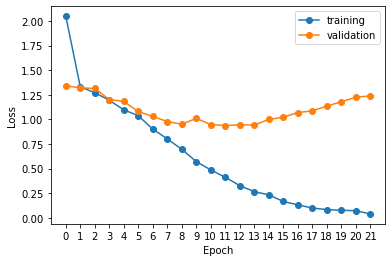

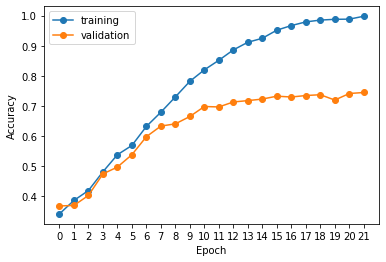

 31/251 [==>...........................] - ETA: 0s - loss: 1.1212 - accuracy: 0.7460

2022-07-10 23:12:28.456824: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_180754"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

251/251 [==============================] - 1s 4ms/step - loss: 1.2027 - accuracy: 0.7550

Test Acc. 75.50%


In [17]:
model3,history3 = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40, 
                              num_of_conv_layer=3)

history3_data = pd.DataFrame(history3.history)
plot_loss_history(history3_data)
plot_accuracy_history(history3_data)

# test model
test3_results = model3.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test3_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 861, 128)          24704     
_________________________________________________________________
pool_3 (MaxPooling

2022-07-10 23:20:47.216810: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_181779"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
750/752 [============================>.] - ETA: 0s - loss: 12.0204 - accuracy: 0.3238

2022-07-10 23:21:05.488637: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_185558"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

752/752 [==============================] - 21s 23ms/step - loss: 11.9856 - accuracy: 0.3240 - val_loss: 1.2579 - val_accuracy: 0.4244

Epoch 00001: val_accuracy improved from -inf to 0.42438, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 16s 21ms/step - loss: 1.2964 - accuracy: 0.4177 - val_loss: 1.2662 - val_accuracy: 0.3904

Epoch 00002: val_accuracy did not improve from 0.42438
Epoch 3/40
752/752 [==============================] - 16s 21ms/step - loss: 1.2115 - accuracy: 0.4475 - val_loss: 1.1483 - val_accuracy: 0.4835

Epoch 00003: val_accuracy improved from 0.42438 to 0.48353, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 16s 21ms/step - loss: 1.0876 - accuracy: 0.5319 - val_loss: 1.1465 - val_accuracy: 0.5266

Epoch 00004: val_accuracy improved from 0.48353 to 0.52658, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40
752/752 [==============================] - 16s 21

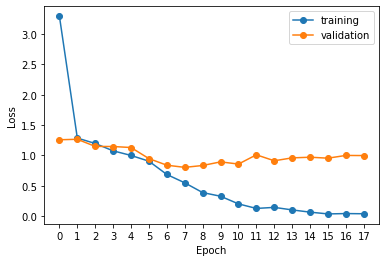

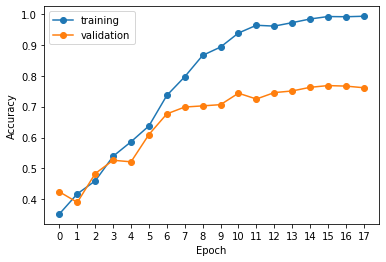

 26/251 [==>...........................] - ETA: 0s - loss: 0.9448 - accuracy: 0.7680

2022-07-10 23:25:58.446621: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_225152"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

251/251 [==============================] - 1s 5ms/step - loss: 1.0639 - accuracy: 0.7661

Test Acc. 76.61%


In [20]:
model4,history4 = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40, 
                              num_of_conv_layer=3, num_of_dense_layer=1)

history4_data = pd.DataFrame(history4.history)
plot_loss_history(history4_data)
plot_accuracy_history(history4_data)

# test model
test4_results = model4.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test4_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 861, 128)          24704     
_________________________________________________________________
pool_3 (MaxPooling

2022-07-10 23:29:46.792007: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_226221"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
751/752 [============================>.] - ETA: 0s - loss: 7.5060 - accuracy: 0.2797

2022-07-10 23:30:05.713954: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_230208"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

752/752 [==============================] - 21s 24ms/step - loss: 7.4928 - accuracy: 0.2797 - val_loss: 1.3770 - val_accuracy: 0.2975

Epoch 00001: val_accuracy improved from -inf to 0.29748, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 16s 22ms/step - loss: 1.3854 - accuracy: 0.2868 - val_loss: 1.3668 - val_accuracy: 0.3025

Epoch 00002: val_accuracy improved from 0.29748 to 0.30247, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 16s 22ms/step - loss: 1.3705 - accuracy: 0.3090 - val_loss: 1.3571 - val_accuracy: 0.3297

Epoch 00003: val_accuracy improved from 0.30247 to 0.32967, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 16s 22ms/step - loss: 1.3445 - accuracy: 0.3378 - val_loss: 1.3408 - val_accuracy: 0.3398

Epoch 00004: val_accuracy improved from 0.32967 to 0.33978, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40

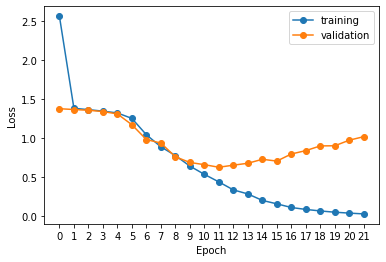

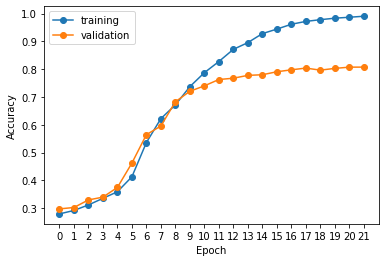

 27/251 [==>...........................] - ETA: 0s - loss: 0.8253 - accuracy: 0.8299

2022-07-10 23:36:19.402499: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_279641"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

251/251 [==============================] - 1s 5ms/step - loss: 1.0239 - accuracy: 0.8152

Test Acc. 81.52%


In [23]:
model5,history5 = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40, 
                              num_of_conv_layer=3, num_of_dense_layer=2)

history5_data = pd.DataFrame(history5.history)
plot_loss_history(history5_data)
plot_accuracy_history(history5_data)

# test model
test5_results = model5.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test5_results[1]*100))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 3445, 32)          128       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1722, 32)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1722, 64)          6208      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 861, 64)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 861, 128)          24704     
_________________________________________________________________
pool_3 (MaxPooling

2022-07-10 23:46:55.746780: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_280754"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

Epoch 1/40
750/752 [============================>.] - ETA: 0s - loss: 6.5060 - accuracy: 0.2680

2022-07-10 23:47:14.577063: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_284949"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

752/752 [==============================] - 21s 24ms/step - loss: 6.4898 - accuracy: 0.2680 - val_loss: 1.3779 - val_accuracy: 0.2926

Epoch 00001: val_accuracy improved from -inf to 0.29261, saving model to ./_best_model_lstm_all_cat.h5
Epoch 2/40
752/752 [==============================] - 16s 22ms/step - loss: 1.3811 - accuracy: 0.2857 - val_loss: 1.3568 - val_accuracy: 0.3295

Epoch 00002: val_accuracy improved from 0.29261 to 0.32955, saving model to ./_best_model_lstm_all_cat.h5
Epoch 3/40
752/752 [==============================] - 17s 22ms/step - loss: 1.3578 - accuracy: 0.3222 - val_loss: 1.3342 - val_accuracy: 0.3516

Epoch 00003: val_accuracy improved from 0.32955 to 0.35163, saving model to ./_best_model_lstm_all_cat.h5
Epoch 4/40
752/752 [==============================] - 16s 22ms/step - loss: 1.3393 - accuracy: 0.3497 - val_loss: 1.3362 - val_accuracy: 0.3579

Epoch 00004: val_accuracy improved from 0.35163 to 0.35787, saving model to ./_best_model_lstm_all_cat.h5
Epoch 5/40

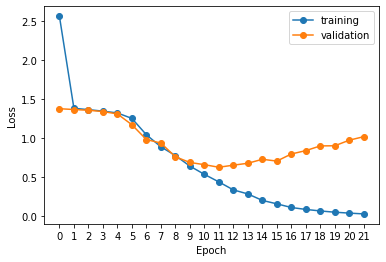

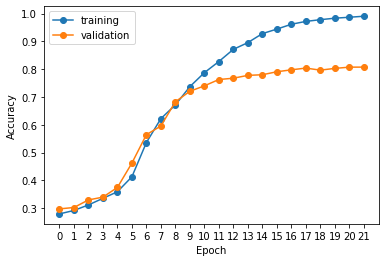

 26/251 [==>...........................] - ETA: 0s - loss: 1.6275 - accuracy: 0.7091

2022-07-10 23:53:27.532073: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_334476"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.a

251/251 [==============================] - 1s 5ms/step - loss: 1.5148 - accuracy: 0.7319

Test Acc. 73.19%


In [26]:
model6,history6 = train_model(X_train, y_train, X_validate, y_validate, save_to= './', epoch = 40, 
                              num_of_conv_layer=3, num_of_dense_layer=3)

history6_data = pd.DataFrame(history5.history)
plot_loss_history(history6_data)
plot_accuracy_history(history6_data)

# test model
test6_results = model6.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test6_results[1]*100))

In [9]:
# train/validate/test
# 1 Conv1D(32): 
#  loss: 0.6173 - accuracy: 0.7622 - val_loss: 0.9949 - val_accuracy: 0.6636
#  test accuracy: 66.82%

# 2 Conv1D(32/64): 
#  loss: 0.1461 - accuracy: 0.9651 - val_loss: 1.1545 - val_accuracy: 0.7219
#  test accuracy: 73.15%

# 3 Conv1D(32/64/128): 
#  loss: 0.0403 - accuracy: 0.9979 - val_loss: 1.2396 - val_accuracy: 0.7446
#  test accuracy: 75.50%

# 3 Conv1D(32/64/128) + 1 Dense(1024): 
#  loss: 0.0315 - accuracy: 0.9937 - val_loss: 0.9972 - val_accuracy: 0.7610
#  test accuracy: 76.61%

# 3 Conv1D(32/64/128) + 2 Dense(1024/512): 
#  loss: 0.0312 - accuracy: 0.9906 - val_loss: 1.0195 - val_accuracy: 0.8076
#  test accuracy: 81.52%

# 3 Conv1D(32/64/128) + 3 Dense(1024/512/256): 
#  loss: 0.0296 - accuracy: 0.9916 - val_loss: 1.6523 - val_accuracy: 0.7166
#  test accuracy: 73.19%

